_______________
# Table of contents
## Von Neumann
1. [One run of VN](#onerun)
2. [On-demand mode](#on_demand) 
3. [Running VN multiple times, fully streaming mode](#fullystreaming)
4. [More efficient implementation of the streaming mode](#fullystreaming2)
5. [Running VN on quantum computers](#qucomp)
6. [VN circuit for the initial concurrence](#initconc)

## Elias
1. [Simulation with 2 qubits](#Elias_simulation)
_______________
#### Execute the next cell first

In [189]:
from qiskit import *
import math
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram
import numpy as np
from scipy.stats import binom
from qiskit.tools.monitor import job_monitor
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sns.set(style="whitegrid", context="paper", palette="colorblind")

_______________
## 1. One Run <a id='onerun'></a>
#### Generating two partially entangled states and executing VN once

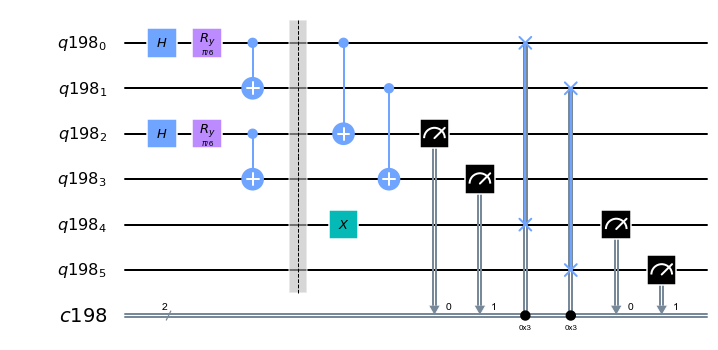

In [153]:
theta = math.pi / 6 # choose theta between -pi/2 and pi/2

# creating the initial entangled state
qr = QuantumRegister(6)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)
circuit.h([0,2])
circuit.ry(theta, [0, 2])

# visualization of the rotation around the y-axis

# simulator = Aer.get_backend('statevector_simulator')
# result = execute(circuit, backend = simulator).result()
# statevector  = result.get_statevector()
# plot_bloch_multivector(statevector) 

circuit.cx([0, 2], [1, 3])
circuit.barrier()
circuit.x(4)
circuit.cx([0, 1], [2, 3])
circuit.measure([2, 3], [0, 1])
circuit.swap([0, 1], [4, 5]).c_if(cr, 3)
circuit.measure([4, 5], [0,1])

circuit.draw(output='mpl')


#### Execute VN on the simulator and plot histogram

{'11': 12403, '00': 12178, '01': 40955}


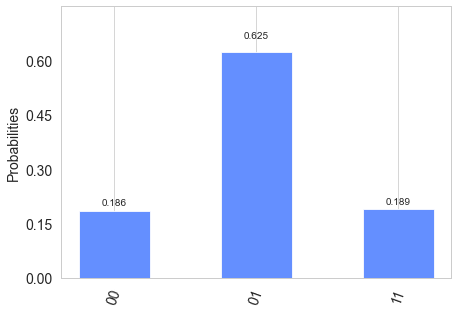

In [154]:
simulator = Aer.get_backend('qasm_simulator')
shots = 2 ** 16
result = execute(circuit, backend = simulator, shots=shots).result()
print(result.get_counts(circuit))
plot_histogram(result.get_counts(circuit))


# 2. On-demand mode <a id='on_demand'></a>
The following blocks execute Von Neumann's protocol for varying numbers of iterations and theta, and check what the probability of succeeding at least once is (with 95% confidence intervals). This probability is plotted and compared to the theoretical binomial distribution. 

In [182]:
results = []
for N in range(1, 7):
    for theta in np.linspace(-math.pi / 2, math.pi / 2, 7):
    # divide the interval -pi/2 to pi/2 in 7 data points, including the boundaries

        # creating the initial entangled state
        qr = QuantumRegister(6)
        cr = ClassicalRegister(2)
        circuit = QuantumCircuit(qr, cr)
        circuit.h([0,2])
        circuit.ry(theta, [0, 2])

        circuit.cx([0, 2], [1, 3])
        circuit.barrier()
        circuit.x(4)
        circuit.cx([0, 1], [2, 3])
        circuit.measure([2, 3], [0, 1])
        circuit.swap([0, 1], [4, 5]).c_if(cr, 3)
        circuit.measure([4, 5], [0,1])

        circuit.draw(output='mpl')
        for _ in range(8192):
            simulator = Aer.get_backend('qasm_simulator')
            shots = N
            result = execute(circuit, backend = simulator, shots=shots).result()
            success = int('11' in result.get_counts(circuit))
            results.append((N, theta, success))

KeyboardInterrupt: 

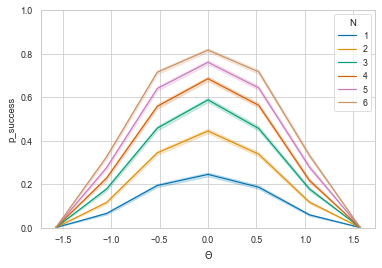

In [119]:
data = pd.DataFrame(results, columns=["N", "theta", "p_success"])
data["N"] = data["N"].astype("category")
sns.lineplot(x="theta", y="p_success", hue="N", data=data)
plt.ylim(0, 1)
plt.xlabel("$\Theta$")
plt.savefig('VN_on_demand.pdf')


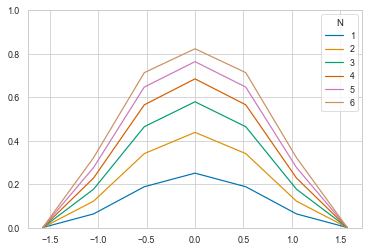

In [121]:
for N in range(1, 7):
    p = p_0 * p_1
    theta = np.linspace(-math.pi / 2, math.pi / 2, 7)
    p_0 = ((np.cos(theta / 2) - np.sin(theta / 2)) / math.sqrt(2)) ** 2
    p_1 = ((np.cos(theta / 2) + np.sin(theta / 2)) / math.sqrt(2)) ** 2
    if N == 1:
        p_success = p
    else:
        p_success = 1 - binom(N, 0) * (1 - p) ** (N)
    plt.plot(theta, p_success, label=N)
    plt.ylim(0, 1)
    plt.legend()
plt.legend(title="N")
plt.savefig('VN_on_demand_binom.pdf')


_______________
## 3. Running VN multiple times, fully streaming mode <a id='fullystreaming'></a>

In [ ]:
theta = math.pi / 4 #choose theta between -pi/2 and pi/2
N = 12 # nr of bits we want to read, should be a multiple of 4

_, ax = plt.subplots(1, N // 4, figsize=(20, 6))

for k in range(4, N + 4, 4):
    qr = QuantumRegister(3 * k // 2, 'q')
    cr = ClassicalRegister(2, 'c')
    output = ClassicalRegister(k // 2)
    circuit = QuantumCircuit(qr, cr, output)
    for i in range(k, 3 * k // 2, 2):
        circuit.x(qr[i])
    for i in range(0, k, 4):
        circuit.h([i,i + 2])
        circuit.ry(theta, [i, i + 2])
        circuit.cx([i, i + 2], [i + 1, i + 3])
        circuit.barrier()
        circuit.cx([i, i + 1], [i + 2, i + 3])
        circuit.measure([i + 2, i + 3], [0, 1])
        circuit.barrier()
        for j in range(i // 4, 0, -1): 
            circuit.swap([k + 2 * (j - 1), k + 2 * (j - 1) + 1], [k + 2 * (j - 1) + 2, k + 2 * (j - 1) + 3]).c_if(cr, 3)
        circuit.swap([i, i + 1], [k, k + 1]).c_if(cr, 3)
        circuit.barrier()
    circuit.measure(qr[k:(3 * k // 2)], output[:k // 2])
    simulator = Aer.get_backend('qasm_simulator', precision='single')
    shots = 100
    result = execute(circuit, backend = simulator, shots=shots).result()
#     if k == 12:
#         bar_labels = False
#     else:
#         bar_labels = True
    bar_labels = True
    plot_histogram(result.get_counts(circuit), ax=ax[k//4 - 1], bar_labels=bar_labels)

    plt.tight_layout()

    %matplotlib inline
circuit.draw(output='mpl')

# plt.savefig('VN_streaming.pdf')
    

_______________
## 4. More efficient implementation of the streaming mode <a id='fullystreaming2'></a>
The next block creates a barplot of the number of successes of Von Neumann’s protocol and the theoretical binomial distribution with p = 0.25



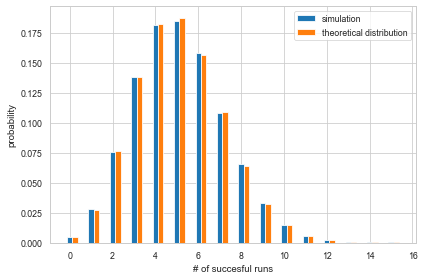

In [192]:
sns.set(style="whitegrid", context="paper", palette="tab10")

theta = math.pi / 4 #choose theta between -pi/2 and pi/2
N = 100000
shots = 40
succes = []
# creating the initial entangled state
qr = QuantumRegister(6)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)
circuit.h([0,2])
circuit.ry(theta, [0, 2])

# visualization of the rotation around the y-axis
simulator = Aer.get_backend('statevector_simulator')
result = execute(circuit, backend = simulator).result()
statevector  = result.get_statevector()
plot_bloch_multivector(statevector) 

circuit.cx([0, 2], [1, 3])
circuit.barrier()
circuit.x(4)
circuit.cx([0, 1], [2, 3])
%matplotlib inline
circuit.draw(output='mpl')
circuit.measure([2, 3], [0, 1])
circuit.swap([0, 1], [4, 5]).c_if(cr, 3)
circuit.measure([4, 5], [0,1])

for i in range(N):
    simulator = Aer.get_backend('qasm_simulator')
    shots = shots
    result = execute(circuit, backend = simulator, shots=shots).result()
    zeroes = int(result.get_counts(circuit).get('00') or 0)
#     ones = int(result.get_counts(circuit).get('11') or 0)
#     succes.append(zeroes + ones)
    succes.append(zeroes)
 
succes_counts = np.bincount(succes, minlength=11)
barwidth = 0.25
r1 = np.arange(len(succes_counts))
r2 = [x + barwidth for x in r1]
plt.bar(r1, succes_counts / N, width=barwidth, label='simulation')
plt.bar(r2, binom.pmf(range(len(succes_counts)), 40, 0.125), width=barwidth, label='theoretical distribution')

plt.legend()
plt.xlabel('# of succesful runs')
plt.ylabel('probability')
plt.tight_layout()
plt.savefig("VN_40_runs.pdf")

In [ ]:
barwidth = 0.25
r1 = np.arange(len(succes_counts))
r2 = [x + barwidth for x in r1]
plt.bar(r1, succes_counts / 1000, width=barwidth, label='simulation')
plt.bar(r2, binom.pmf(range(11), 10, 0.125), width=barwidth, label='binomial distribution')

plt.legend()
plt.xlabel('# of succesful runs')
plt.ylabel('probability')
plt.savefig("VN_10_runs")

_______________
## 5. Running VN on quantum computers <a id='qucomp'></a>
#### Insert your API token to acces IBM Quantum devices via ```IBMQ.save_account()```

In [ ]:
theta = 3 * math.pi / 4 #choose theta between -pi/2 and pi/2
shots = 8192

# creating the initial entangled state
qr = QuantumRegister(4, 'q')
cr = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qr, cr)
# circuit.h([0,2])
# circuit.ry(theta, [0, 2])

circuit.rx(theta, [0,2])
circuit.cx([0, 2], [1, 3])
circuit.barrier()
circuit.cx([0, 1], [2, 3])

circuit.measure([0, 1, 2, 3], [0, 1, 2, 3])

circuit.draw(output='mpl')
# circuit.draw(output='mpl', filename='Von_Neumann_real_qubits_0.pdf')

#### Executing circuit on the simulator for comparison

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
simulator = Aer.get_backend('qasm_simulator', precision='single')
result = execute(circuit, backend = simulator, shots=shots).result()
print(result.get_counts(circuit))
plot_histogram(result.get_counts(circuit), ax=ax)
plt.tight_layout()

# plt.savefig('VN_real_qubits_pi_4_results.pdf')

#### Executing circuit on the quantum computer of your choice
An overview of the available quantum computers: https://quantum-computing.ibm.com/

In [ ]:
IBMQ.load_account()

In [ ]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_santiago') # get the backend you want to execute your circuit on
job = execute(circuit, backend=qcomp, shots=shots)

In [ ]:
job_monitor(job) 

In [ ]:
result = job.result()
_, ax = plt.subplots(figsize=(10, 5))
plot_histogram(result.get_counts(circuit), ax=ax)
plt.tight_layout()

# plt.savefig('VN_real_qubits_santiago_pi_4_2.pdf')

_______________
## 6. VN circuit for the initial concurrence<a id='initconc'></a>

In [ ]:
from qiskit import *
import math
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
%matplotlib inline
import matplotlib.pyplot as plt

#calculating the initial concurrence
theta = math.pi / 3 #choose theta between -pi/2 and pi/2

# creating the initial entangled state
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qr, cr)
circuit.h(0)
circuit.ry(theta, 0)
circuit.cx(0, 1)

circuit.measure([0,1], [0,1])

circuit.draw('mpl')

In [ ]:
simulator = Aer.get_backend('qasm_simulator', precision='single')
shots = 100000
result = execute(circuit, backend = simulator, shots=shots).result()
print(result.get_counts(circuit))
plot_histogram(result.get_counts(circuit))

# plt.savefig('VN_init_conc_sim_pi_6.pdf')

In [ ]:
IBMQ.load_account()

In [ ]:
shots = 8192
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_santiago')
job = execute(circuit2, backend=qcomp, shots=shots)


In [ ]:
job_monitor(job)


In [ ]:
result = job.result()
_, ax = plt.subplots(figsize=(10, 5))
plot_histogram(result.get_counts(circuit2), ax=ax)
plt.tight_layout()

# plt.savefig('VN_init_conc_yorktown_pi_6.pdf')


In [ ]:
print(result.get_counts(circuit2))


___________________________________________________
___________________________________________________
# 1. Elias's Protocol
## Measuring the Hamming weight for Elias with N = 2 <a id='Elias_simulation'></a>

In the following cell, we define two functions that respectively implement the half adder and the hamming weight for the simulator.

In [132]:
def half_adder(carry, ancilla, zero):
    circuit.ccx(carry, ancilla, zero)
    circuit.cx(carry, ancilla)
    circuit.swap(carry, zero)
    circuit.reset(zero)
    circuit.barrier()
    
def hamming_weight(qubits, carry, ancillas, zero):
    # after the last half adder, the carry is reset so that it can be reused if necessary
    N = len(qubits)
    for i in range(N):
        circuit.cx(qubits[i], carry)
        for j in range(min(i + 1, len(ancillas))):
            half_adder(carry, ancillas[j], zero)
    circuit.reset(carry) 

In [180]:
theta = math.pi / 6 # choose theta between -pi/2 and pi/2
N = 4 #number of states Alice and Bob begin with (first one for Alice, second one for Bob, etcetera)

# creating the initial entangled state
qr = QuantumRegister(N, 'q')
carry = QuantumRegister(1, 'carry')
ancilla_A = QuantumRegister(2, 'a')
ancilla_B = QuantumRegister(2, 'b')
zero = QuantumRegister(1, 'z')
cr = ClassicalRegister(8, 'c')
circuit = QuantumCircuit(qr, carry, ancilla_A, ancilla_B, zero, cr)
circuit.h(range(0, N, 2))
circuit.ry(theta, range(0, N, 2))
circuit.cx(range(0, N, 2), range(1, N, 2))
circuit.barrier()

hamming_weight([0, 2], carry, ancilla_A, zero)
hamming_weight([1, 3], carry, ancilla_B, zero)

circuit.measure([0, 1, 2, 3, 5, 6, 7, 8], [4, 5, 6, 7, 0, 1, 2, 3])
# circuit.draw(output='mpl', filename='Elias_simulation_2.pdf')


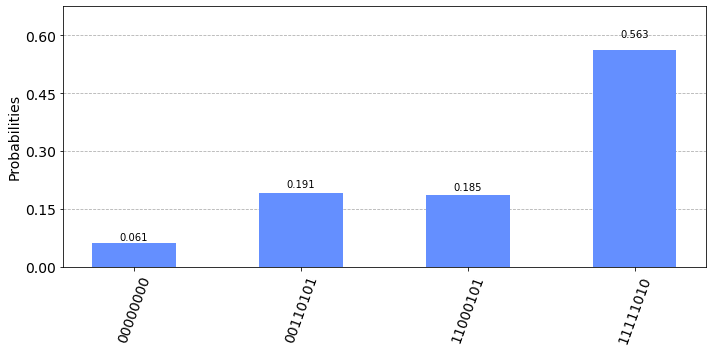

In [181]:
shots = 2**16
_, ax = plt.subplots(figsize=(10, 5))
simulator = Aer.get_backend('qasm_simulator')
results = execute(circuit, backend=simulator, shots=shots).result()
plot_histogram(results.get_counts(circuit), ax=ax)
plt.tight_layout()

# plt.savefig('Elias_simulation_2_hist_2_16_pi_3.pdf')

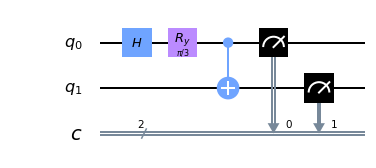

In [174]:
theta = math.pi / 3 # choose theta between -pi/2 and pi/2
N = 2 #number of states Alice and Bob begin with (first one for Alice, second one for Bob, etcetera)

# creating the initial entangled state
qr = QuantumRegister(N, 'q')
cr = ClassicalRegister(N, 'c')
circuit2 = QuantumCircuit(qr, cr)
circuit2.h(range(0, N, 2))
circuit2.ry(theta, range(0, N, 2))
circuit2.cx(range(0, N, 2), range(1, N, 2))

circuit2.measure([0, 1], [0, 1])


circuit2.draw(output='mpl')


In the next cells we run on the 15-qubit quantum processor Melbourne.

In [175]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-04-14 15:00:44,187: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [176]:
shots = 8192
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')
job = execute(circuit2, backend=qcomp, shots=shots)

In [177]:
job_monitor(job)


Job Status: job is queued (None)  

KeyboardInterrupt: 

In [ ]:
sns.reset_orig()
result = job.result()
_, ax = plt.subplots(figsize=(10, 5))
plot_histogram(result.get_counts(circuit2), ax=ax)
plt.tight_layout()

plt.savefig('Elias_real_qubits_init_melb_pi_3_2.pdf')